In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

from astropy.io import fits
from scipy.spatial import KDTree
from scipy.stats import gaussian_kde

In [2]:
hdul = fits.open('../data/apogee_astroNN-DR17.fits')

In [3]:
for key in hdul[1].header.keys():
    if 'TTYPE' in key:
        print(hdul[1].header[key])

APOGEE_ID
LOCATION_ID
TELESCOPE
RA_APOGEE
DEC_APOGEE
TEFF
TEFF_ERR
LOGG
LOGG_ERR
C_H
C_H_ERR
CI_H
CI_H_ERR
N_H
N_H_ERR
O_H
O_H_ERR
NA_H
NA_H_ERR
MG_H
MG_H_ERR
AL_H
AL_H_ERR
SI_H
SI_H_ERR
P_H
P_H_ERR
S_H
S_H_ERR
K_H
K_H_ERR
CA_H
CA_H_ERR
TI_H
TI_H_ERR
TIII_H
TIII_H_ERR
V_H
V_H_ERR
CR_H
CR_H_ERR
MN_H
MN_H_ERR
FE_H
FE_H_ERR
CO_H
CO_H_ERR
NI_H
NI_H_ERR
dist
dist_error
dist_model_error
nn_parallax
nn_parallax_error
nn_parallax_model_error
fakemag
fakemag_error
weighted_dist
weighted_dist_error
RA
DEC
pmra
pmra_error
ref_epoch
pmdec
pmdec_error
phot_g_mean_mag
bp_rp
g_rp
VHELIO_AVG
age
age_linear_correct
age_lowess_correct
age_total_error
age_model_error
source_id
galr
galphi
galz
galvr
galvt
galvz
galr_err
galphi_err
galz_err
galvr_err
galvt_err
galvz_err
galvr_galvt_corr
galvr_galvz_corr
galvt_galvz_corr
e
e_err
zmax
zmax_err
rperi
rperi_err
rap
rap_err
e_zmax_corr
e_rperi_corr
e_rap_corr
zmax_rperi_corr
zmax_rap_corr
rperi_rap_corr
jr
jr_err
Lz
Lz_err
jz
jz_err
jr_Lz_corr
jr_jz_corr
lz_jz

In [4]:
Lz = hdul[1].data.Lz
zmax = hdul[1].data.zmax

logFeH = hdul[1].data.FE_H
logMgH = hdul[1].data.MG_H
logMgFe = logMgH - logFeH

e_logFeH = hdul[1].data.FE_H_ERR
e_logMgH = hdul[1].data.MG_H_ERR
e_logMgFe = np.sqrt(e_logFeH**2 + e_logMgH**2)

FeH = 10.**logFeH
MgH = 10.**logMgH
MgFe = 10.**logMgFe

age = hdul[1].data.age
# age1 = hdul[1].data.age_linear_correct
# age2 = hdul[1].data.age_lowess_correct

age_err = hdul[1].data.age_total_error

t_form = 13.813 - age

/tmp/ipykernel_3308211/981922340.py:12: RuntimeWarning: overflow encountered in power
  FeH = 10.**logFeH
/tmp/ipykernel_3308211/981922340.py:13: RuntimeWarning: overflow encountered in power
  MgH = 10.**logMgH
/tmp/ipykernel_3308211/981922340.py:14: RuntimeWarning: overflow encountered in power
  MgFe = 10.**logMgFe


In [5]:
logg = hdul[1].data.LOGG
logg_err = hdul[1].data.LOGG_ERR

In [6]:
vsun = 220
Rsun = 8
Lzsun = Rsun * vsun

Lz_diff = np.abs(Lz/Lzsun - 1)

in_SN = np.logical_and(Lz_diff < 0.05 , zmax<3)
in_SN = np.logical_and(in_SN, logg_err < 0.2)
in_SN = np.logical_and(in_SN, age_err/age < 0.2)
in_SN = np.logical_and(in_SN, logg < 3.5)
print(len(np.where(in_SN)[0]))

13069


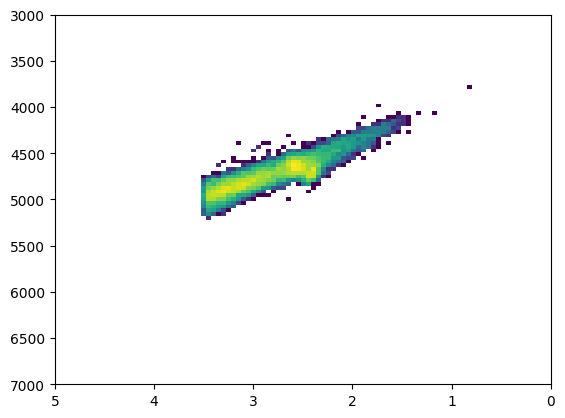

In [7]:
Teff = hdul[1].data.TEFF

xbins = np.linspace(0, 5, 100)
ybins = np.linspace(3000, 7000, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(logg[in_SN], Teff[in_SN], np.full(len(logg[in_SN]), 1), 
                                                     statistic='sum', bins=[xbins, ybins])
    
plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

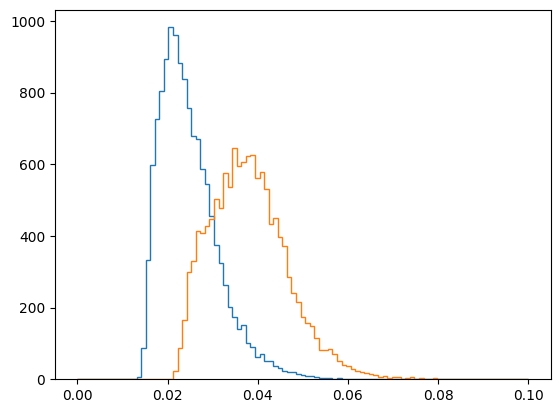

In [8]:
plt.hist(e_logFeH[in_SN], bins=np.linspace(0, 0.1, 100), histtype='step');
plt.hist(e_logMgFe[in_SN], bins=np.linspace(0, 0.1, 100), histtype='step');

Text(0, 0.5, 'age error [Gyr]')

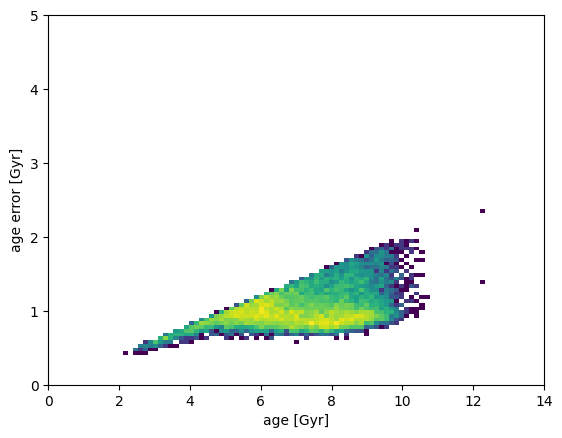

In [9]:
# plt.hist(age_err[in_SN]/age[in_SN], bins=np.linspace(0, 1, 100));

age_bins  = np.linspace(0, 14, 100)
age_err_bins = np.linspace(0, 5, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], age_err[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, age_err_bins])
# mbin, x_edge, y_edge, _ = binned_statistic_2d(age, age_err, np.full(len(age), 1), 
                                                     # statistic='sum', bins=[age_bins, age_err_bins])
    
plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')

# plt.plot(aveFe, aveMgFe, c='r')

plt.xlabel('age [Gyr]')
plt.ylabel('age error [Gyr]')

# plt.plot(avet, aveMgFe)

In [10]:
def plot_map(fig, ax, logFeH, logMgFe, scalar=None, subsamp=None, tform=None, tform_min=0, tform_max=10,
             exclude=None, nres=50, sigma=1,
             logFeH_min=-1.1, logFeH_max=0.4, logMgFe_min=0.15, logMgFe_max=0.65,
             K=64, vmin=None, vmax=None, asymmetry=False, norm=0, cmap=None):
    
    if exclude is not None:
        key = np.logical_or(tform < exclude[0], tform > exclude[1])
    else:
        key = np.full(len(logFeH), True)
    
    data = np.vstack((logFeH[key], logMgFe[key])).T
    N = len(data)
    tree = KDTree(data)
        
    dlogFeH = (logFeH_max - logFeH_min)/nres
    dlogMgFe = (logMgFe_max - logMgFe_min)/nres
        
    logFeH_lin = np.linspace(logFeH_min + dlogFeH, logFeH_max-dlogFeH, nres)
    logMgFe_lin = np.linspace(logMgFe_min + dlogMgFe, logMgFe_max-dlogMgFe, nres)
    
    logFeH_grid, logMgFe_grid = np.meshgrid(logFeH_lin, logMgFe_lin)
    grid = np.vstack([logFeH_grid.ravel(), logMgFe_grid.ravel()]).T

    distances, indices = tree.query(grid, k=K)
    kth_distances = distances[:, -1]
    
    # Calculate the density: Inverse of the area of the circle surrounding the Kth neighbor
    density = K / (N * np.pi * kth_distances**2)
    density = np.reshape(density, logFeH_grid.shape).T
    
    downstairs = np.max(density, axis=1)
    
    # downstairs = np.sum(mbin, axis=1)
    # vmin = 0.01
    # vmax = 0.2
    
    if norm == 0:
        # norm = None
        # norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        # norm = mpl.colors.PowerNorm(gamma=0.5)
    
    downstairs[downstairs == 0.0] = 1e-20
    density = (density.T / downstairs).T
    density[density < norm.vmin] = norm.vmin
        
    extent = [logFeH_min, logFeH_max, logMgFe_min, logMgFe_max]
    
    im = ax.imshow(density.T, origin='lower',
               extent=extent,
               norm=norm, cmap=cmap)

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect('auto')
    
    return im

Text(0, 0.5, '[Mg/Fe]')

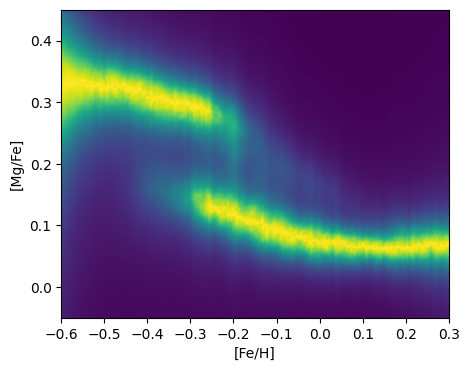

In [11]:
logFeH_min=-0.6 
logFeH_max=0.3
logMgFe_min=-0.05
logMgFe_max=0.45

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

im = plot_map(fig, ax, logFeH[in_SN], logMgFe[in_SN], nres=256,
              logFeH_min=logFeH_min, logFeH_max=logFeH_max, 
              logMgFe_min=logMgFe_min, logMgFe_max=logMgFe_max,
              K=256, norm=mpl.colors.Normalize(vmin=0, vmax=1.0))

ax.set(xlabel='[Fe/H]')
ax.set(ylabel='[Mg/Fe]')

ax.set_xlim(logFeH_min, logFeH_max)
ax.set_ylim(logMgFe_min, logMgFe_max)
ax.set_aspect('auto')

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Mg/Fe]')

Text(0, 0.5, '[Mg/Fe]')

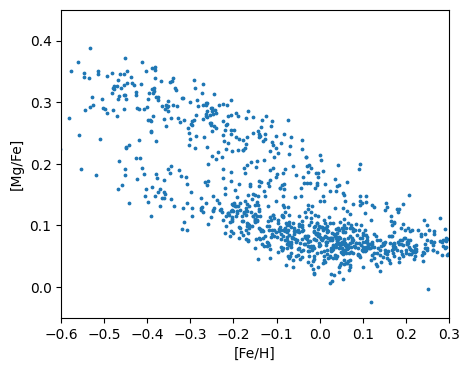

In [12]:
logFeH_min=-0.6 
logFeH_max=0.3
logMgFe_min=-0.05
logMgFe_max=0.45

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# print(np.sum(in_SN))
subsamp = 1000
in_SN_sub = np.random.choice(np.where(in_SN)[0], subsamp, replace=False)
ax.scatter(logFeH[in_SN_sub], logMgFe[in_SN_sub], s=3)

ax.set(xlabel='[Fe/H]')
ax.set(ylabel='[Mg/Fe]')

ax.set_xlim(logFeH_min, logFeH_max)
ax.set_ylim(logMgFe_min, logMgFe_max)
ax.set_aspect('auto')

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Mg/Fe]')

Text(0.5, 1.0, '-0.35 < [Fe/H] < -0.25')

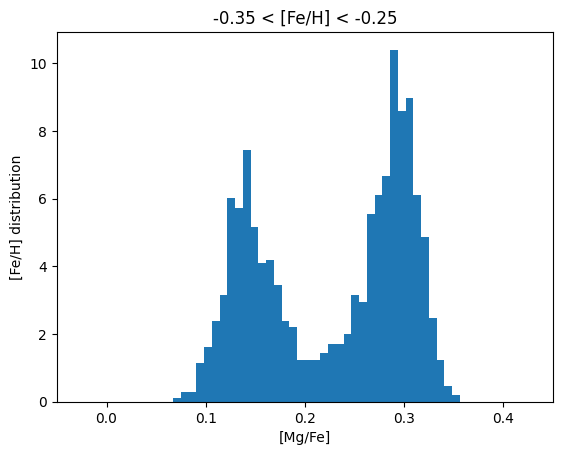

In [13]:
key = np.logical_and(logFeH > -0.35, logFeH < -0.25)
key = np.logical_and(key, in_SN)

bins = np.linspace(-0.05, 0.45, 64+1)

plt.hist(logMgFe[key], bins=bins, density=True);
# plt.yscale('log')
plt.xlabel('[Mg/Fe]')
plt.ylabel('[Fe/H] distribution')
plt.xlim(bins[0], bins[-1])
plt.title('-0.35 < [Fe/H] < -0.25')

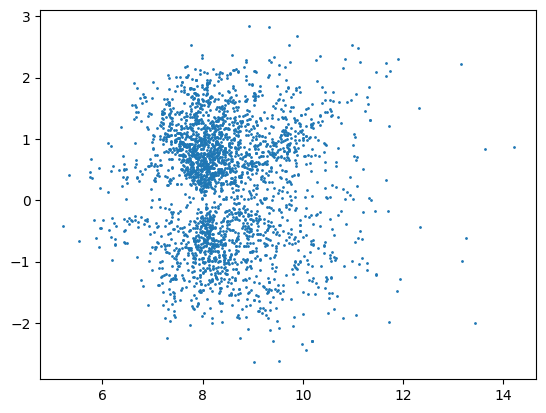

In [14]:
# spatial extent of high alpha stars
high_alpha = logMgFe > 0.22
high_alpha_in_SN = np.logical_and(high_alpha, in_SN)

galr = hdul[1].data.galr
galz = hdul[1].data.galz

plt.scatter(galr[high_alpha_in_SN], galz[high_alpha_in_SN], s=1)

In [15]:
def make_plot():
    logFeH_min=-0.6
    logFeH_max=0.3
    logMgFe_min=-0.05
    logMgFe_max=0.45

    dlogFeH = 0.1

    fig, axs = plt.subplots(4, 1, figsize=(4, 12))

    subsamp = 5000
    key = np.where(in_SN)[0]
    # key = np.random.choice(key, subsamp, replace=False)
                        
    axs[0].scatter(logFeH[key], logMgFe[key], s=1, alpha=0.5, c='k')
    axs[0].set(xlim=(logFeH_min, logFeH_max), ylim=(logMgFe_min, logMgFe_max))
    
    axs[0].set_title('APOGEE')
    axs[0].set(xlabel='[Fe/H]', ylabel='[Mg/Fe]')

    # for logFeH0 in [-0.75, -0.5, -0.25, 0, 0.25]:
    offset = -0.3
    # for i,logFeH0 in enumerate([-0.5, -0.25, 0, 0.25]):
    for i,logFeH0 in enumerate([-0.45, -0.3, -0.05, 0.1]):
        key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
        key = np.logical_and(key, in_SN)
    
        kernel = gaussian_kde(logMgFe[key])
        xlist = np.linspace(-3, 3, 1000+1)
        val = kernel(xlist)
            
        # l = axs[1].plot(xlist+offset, val)
        _, _, l = axs[1].hist(logMgFe[key]+offset, bins=np.linspace(logMgFe_min-0.2, logMgFe_max+0.4, 100+1))
        # print(l)
        c = l[0].get_facecolor()
        axs[0].axvline(logFeH0, c=c)
    
        offset += 0.3
    
#         # SFH
#         # tform = gal.sn.part4.GFM_StellarFormationTime
#         tform = get_time(snap[4]['GFM_StellarFormationTime'])
#         # kernel = gaussian_kde(tform[key], bw_method='silverman')
#         # xlist = np.linspace(0, 8, 1000+1)
#         # val = kernel(xlist)
    
#         # axs[2].plot(xlist, val, c=c)
#         # if i==0 or i==3:
#         if False:
#             alpha=0.8
#             lw = 1
#         else:
#             alpha=1
#             lw = 1.45
#         h = axs[2].hist(tform[key], bins=np.linspace(0, 14, 64+1), histtype='step', alpha=alpha, lw=lw)
    
#         # alpha vs tform
#         key = np.where(key)[0]
#         # key = np.random.choice(key, int(0.1*len(key) + 0.5), replace=False)
#         # key = np.random.choice(key, 2000, replace=False)
#         axs[3].scatter(tform[key], logMgFe[key]+offset, alpha=0.3, color=c, s=0.1)

    axs[1].set(xlim=(logMgFe_min-0.2, logMgFe_max+0.4), ylim=(0, None))
    axs[2].set(xlim=(0, 14), ylim=(0, None))

    axs[1].set(xlabel='[Mg/Fe] + offset', ylabel='count')
    axs[2].set(xlabel='formation time [Gyr]', ylabel='count')
    axs[3].set(xlabel='formation time [Gyr]', ylabel='[Mg/Fe] + offset')

    fig.tight_layout()
    
    fig.savefig('fig/APOGEE.png')
    
    plt.close()

In [25]:
make_plot()

Text(0, 0.5, '[Fe/H]')

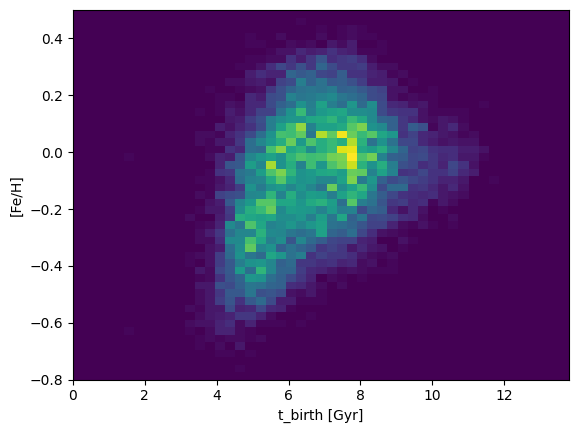

In [26]:
tbirth_bins  = np.linspace(0, 13.8, 50)
logFe_bins = np.linspace(-0.8, 0.5, 50)

# mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     # statistic='sum', bins=[logFeH_bins, logMgFe_bins])


tbirth = 13.8 - age

mbin, x_edge, y_edge, _ = binned_statistic_2d(tbirth[in_SN], logFeH[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[tbirth_bins, logFe_bins])
# downstairs = np.max(mbin, axis=1)
# downstairs[downstairs == 0.0] = 1e-20
# mbin = (mbin.T / downstairs).T

plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
# plt.xlim(logFeH_bins[0], logFeH_bins[-1])
# plt.ylim(logMgFe_bins[0], logMgFe_bins[-1])
plt.gca().set_aspect('auto')

plt.xlabel('t_birth [Gyr]')
plt.ylabel('[Fe/H]')

(0.0, 100.0)


Text(0, 0.5, '[Mg/Fe]')

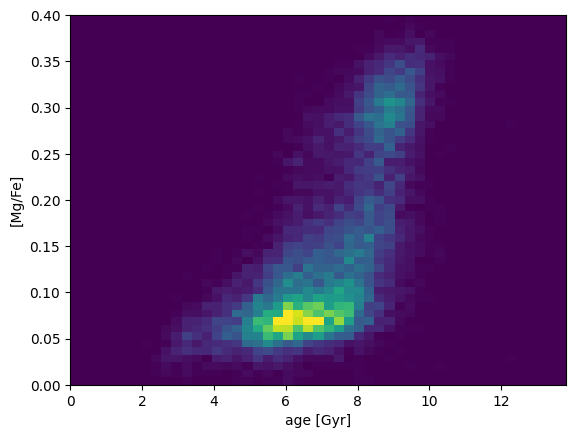

In [29]:
tbirth_bins  = np.linspace(0, 13.8, 50)
logMgFe_bins = np.linspace(0, 0.4, 50)

# mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     # statistic='sum', bins=[logFeH_bins, logMgFe_bins])


tbirth = 13.8 - age

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[tbirth_bins, logMgFe_bins])
# downstairs = np.max(mbin, axis=1)
# downstairs[downstairs == 0.0] = 1e-20
# mbin = (mbin.T / downstairs).T

im = plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
               vmin=0, vmax=100)#, norm=mpl.colors.LogNorm())
# plt.xlim(logFeH_bins[0], logFeH_bins[-1])
# plt.ylim(logMgFe_bins[0], logMgFe_bins[-1])
plt.gca().set_aspect('auto')

print(im.get_clim())

plt.xlabel('age [Gyr]')
plt.ylabel('[Mg/Fe]')

In [ ]:
age_bins  = np.linspace(0, 12, 64)
logFeH_bins = np.linspace(-0.6, 0.5, 64)
logMgFe_bins = np.linspace(-0.6, 0.5, 64)

aveFe, _, _ = binned_statistic(age[in_SN], FeH[in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(age[in_SN], MgFe[in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(age[in_SN], age[in_SN], bins=age_bins)
logaveFe = np.log10(aveFe)
logaveMgFe = np.log10(aveMgFe)

fig, ax = plt.subplots(4, 1, figsize=(4, 12), sharex=False)

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logFeH[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logFeH_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[0].plot(aveage, logaveFe, c='r')
ax[0].set(aspect='auto', ylabel='[Fe/H]')

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logMgH[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logMgFe_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[1].set(aspect='auto', xlabel='age [Gyr]', ylabel='[Mg/H]')
ax[1].plot(aveage, logaveMgFe, c='r')

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logMgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logMgFe_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[2].set(aspect='auto', xlabel='age [Gyr]', ylabel='[Mg/Fe]')
ax[2].plot(aveage, logaveMgFe, c='r')

# logMgH_in_SN_shuffle = np.copy(logMgH[in_SN])
# np.random.shuffle(logMgH_in_SN_shuffle)
# logMgFe_fake_in_SN = logFeH[in_SN] - logMgH_in_SN_shuffle

key = np.argsort(logFeH[in_SN])
logMgFe_fake_in_SN = logFeH[in_SN] - logMgH[in_SN][key]

mbin, x_edge, y_edge, _ = binned_statistic_2d(age[in_SN], logMgFe_fake_in_SN, np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[age_bins, logMgFe_bins])
mbin = (mbin.T / np.max(mbin, axis=1)).T
ax[3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
ax[3].set(aspect='auto', xlabel='age [Gyr]', ylabel='[Mg/Fe]')
ax[3].plot(aveage, logaveMgFe, c='r')

In [ ]:
logMgH_in_SN_shuffle = np.copy(logMgH[in_SN])
print(logMgH_in_SN_shuffle[:4])
np.random.shuffle(logMgH_in_SN_shuffle)
print(logMgH_in_SN_shuffle[:4])

In [ ]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
logFeH_bins = np.linspace(-0.6, 0.5, 64)
logMgFe_bins = np.linspace(-0.2, 0.4, 64)

aveFe, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(t_form[in_SN], MgFe[in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins)
logaveFe = np.log10(aveFe)
logaveMgFe = np.log10(aveMgFe)

logaveFe_interp = interp1d(aveage, logaveFe, bounds_error=False, fill_value='extrapolate')
logaveMgFe_interp = interp1d(aveage, logaveMgFe, bounds_error=False, fill_value='extrapolate')

logaveFe_pred = logaveFe_interp(t_form)
logaveMgFe_pred = logaveMgFe_interp(t_form)

fig, ax = plt.subplots(1, 1)

mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN]-logaveFe_pred[in_SN], 
                                              logMgFe[in_SN]-logaveMgFe_pred[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgFe_bins])
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax.set(aspect='auto', ylabel='residual [Mg/Fe]', xlabel='residual [Fe/H]')

# mbin, x_edge, y_edge, _ = binned_statistic_2d(t_form[in_SN], MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
#                                                      statistic='sum', bins=[age_bins, MgFe_bins])
# ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
# ax[1].set(aspect='auto', xlabel='formation time [Gyr]', ylabel='[Mg/Fe]')
# ax[1].plot(aveage, aveMgFe)

In [ ]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(-1, 1, 64)
MgFe_bins = np.linspace(-0.5, 0.8, 64)

t_form = 13.813 - age

aveFe, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins)
aveMgFe, _, _ = binned_statistic(t_form[in_SN], MgFe[in_SN], bins=age_bins)
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins)
# aveFe = np.log10(aveFe)
# aveMgFe = np.log10(aveMgFe)

aveFe_interp = interp1d(aveage, aveFe, bounds_error=False, fill_value='extrapolate')
aveMgFe_interp = interp1d(aveage, aveMgFe, bounds_error=False, fill_value='extrapolate')

aveFe_pred = aveFe_interp(t_form)
aveMgFe_pred = aveMgFe_interp(t_form)

fig, ax = plt.subplots(1, 1)

mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[in_SN]-aveFe_pred[in_SN], 
                                              MgFe[in_SN]-aveMgFe_pred[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgFe_bins])
ax.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax.set(aspect='auto', ylabel='residual Z_Mg/Z_Fe', xlabel='residual Z_Fe')

# mbin, x_edge, y_edge, _ = binned_statistic_2d(t_form[in_SN], MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
#                                                      statistic='sum', bins=[age_bins, MgFe_bins])
# ax[1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
# ax[1].set(aspect='auto', xlabel='formation time [Gyr]', ylabel='[Mg/Fe]')
# ax[1].plot(aveage, aveMgFe)

In [ ]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(0, 2.5, 64)
MgH_bins = np.linspace(0, 2.5, 64)
resid_FeH_bins = np.linspace(-1, 1.5, 64)
resid_MgH_bins = np.linspace(-1, 1.5, 64)

aveFeH, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins, statistic='median')
aveMgH, _, _ = binned_statistic(t_form[in_SN], MgH[in_SN], bins=age_bins, statistic='median')
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins, statistic='median')
# aveFe = np.log10(aveFe)
# aveMgFe = np.log10(aveMgFe)

aveFeH_interp = interp1d(aveage, aveFeH, bounds_error=False, fill_value='extrapolate')
aveMgH_interp = interp1d(aveage, aveMgH, bounds_error=False, fill_value='extrapolate')

aveFeH_pred = aveFeH_interp(t_form)
aveMgH_pred = aveMgH_interp(t_form)

fig, ax = plt.subplots(2, 4, figsize=(14, 6))

resid_FeH = FeH - aveFeH_pred
resid_MgH = MgH - aveMgH_pred

mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[in_SN], 
                                              MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][0].set(aspect='auto', ylabel='Z_Mg', xlabel='Z_Fe')
ax[0][0].set_title('all stars in SN')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[in_SN], 
                                              resid_MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][0].set(aspect='auto', ylabel='residual Z_Mg', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][1].set(aspect='auto', xlabel='Z_Fe')
ax[0][1].set_title('t_form = 5 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][1].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][2].set(aspect='auto', xlabel='Z_Fe')
ax[0][2].set_title('t_form = 8 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][2].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[key], 
                                              MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[FeH_bins, MgH_bins])
ax[0][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][3].set(aspect='auto', xlabel='Z_Fe')
ax[0][3].set_title('t_form = 12 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
ax[1][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][3].set(aspect='auto', xlabel='residual Z_Fe')

fig.tight_layout()

In [ ]:
from scipy.interpolate import interp1d

age_bins  = np.linspace(0, 13.5, 64)
FeH_bins = np.linspace(0, 2.5, 64)
MgH_bins = np.linspace(0, 2.5, 64)
logFeH_bins = np.linspace(-1, 0.5, 64)
logMgH_bins = np.linspace(-1, 0.5, 64)
resid_FeH_bins = np.linspace(-1, 1.5, 64)
resid_MgH_bins = np.linspace(-1, 1.5, 64)

aveFeH, _, _ = binned_statistic(t_form[in_SN], FeH[in_SN], bins=age_bins, statistic='median')
aveMgH, _, _ = binned_statistic(t_form[in_SN], MgH[in_SN], bins=age_bins, statistic='median')
aveage, _, _ = binned_statistic(t_form[in_SN], t_form[in_SN], bins=age_bins, statistic='median')
# aveFe = np.log10(aveFe)
# aveMgFe = np.log10(aveMgFe)

aveFeH_interp = interp1d(aveage, aveFeH, bounds_error=False, fill_value='extrapolate')
aveMgH_interp = interp1d(aveage, aveMgH, bounds_error=False, fill_value='extrapolate')

aveFeH_pred = aveFeH_interp(t_form)
aveMgH_pred = aveMgH_interp(t_form)

fig, ax = plt.subplots(2, 4, figsize=(14, 6))

resid_FeH = FeH - aveFeH_pred
resid_MgH = MgH - aveMgH_pred

mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[in_SN], 
                                              logMgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][0].set(aspect='auto', ylabel='Z_Mg', xlabel='Z_Fe')
ax[0][0].set_title('all stars in SN')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[in_SN], 
                                              resid_MgH[in_SN], 
                                              np.full(len(np.where(in_SN)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][0].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][0].set(aspect='auto', ylabel='residual Z_Mg', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], 
                                              logMgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][1].set(aspect='auto', xlabel='Z_Fe')
ax[0][1].set_title('t_form = 5 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][1].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][1].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], 
                                              logMgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][2].set(aspect='auto', xlabel='Z_Fe')
ax[0][2].set_title('t_form = 8 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][2].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][2].set(aspect='auto', xlabel='residual Z_Fe')

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
mbin, x_edge, y_edge, _ = binned_statistic_2d(logFeH[key], 
                                              logMgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[logFeH_bins, logMgH_bins])
ax[0][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[0][3].set(aspect='auto', xlabel='Z_Fe')
ax[0][3].set_title('t_form = 12 Gyr')

mbin, x_edge, y_edge, _ = binned_statistic_2d(resid_FeH[key], 
                                              resid_MgH[key], 
                                              np.full(len(np.where(key)[0]), 1), 
                                              statistic='sum', bins=[resid_FeH_bins, resid_MgH_bins])
# ax[1][3].imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
ax[1][3].set(aspect='auto', xlabel='residual Z_Fe')

fig.tight_layout()

In [ ]:
density = True

bins = np.linspace(0, 3, 100)
logbins = np.linspace(-0.5, 0.5, 100)

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
ax[0].hist(FeH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logFeH[key], histtype='step', density=density, bins=logbins);


In [ ]:
density = True

bins = np.linspace(0, 3, 100)
logbins = np.linspace(-0.5, 0.5, 100)

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

key = np.logical_and(t_form > 4.5, t_form < 5.5)
key = np.logical_and(key, in_SN)
ax[0].hist(MgH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logMgH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(key, in_SN)
ax[0].hist(MgH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logMgH[key], histtype='step', density=density, bins=logbins);

key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)
ax[0].hist(MgH[key], histtype='step', density=density, bins=bins);
ax[1].hist(logMgH[key], histtype='step', density=density, bins=logbins);


In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
multivariate_normal.fit?

In [ ]:
t_min = 0
dt = 1.0

avet_form = []
mu = []
cov = []

while t_min < 13:
    key = np.logical_and(t_form > t_min, t_form < t_min + dt)
    key = np.logical_and(key, in_SN)
    
    avet_form.append(np.mean(t_form[key]))
    
    data = np.transpose([logFeH[key], logMgH[key]])
    mu_, cov_ = multivariate_normal.fit(data)
    mu.append(mu_)
    cov.append(cov_)

    t_min += dt/2.

avet_form = np.array(avet_form)
mu = np.array(mu)
cov = np.array(cov)

var = np.transpose([cov[:,0,0], cov[:,1,1]])
mu_Z = 10.**(mu + var/2.)
# mu_Z = mu

In [ ]:
print(mu[-1])
print(var[-1])
print(mu_Z[-1])

In [ ]:
np.mean(10.**logFeH[key])

In [ ]:
m = np.mean(logFeH[key])
s = np.std(logFeH[key])
print(m, s**2)
print(10.**(m + s**2/2.))

In [ ]:
print('mu.shape:', mu.shape)
print('cov.shape:', cov.shape)

In [17]:
plt.plot(avet_form, mu_Z[:,0])
plt.plot(avet_form, mu_Z[:,1])
# plt.plot(avet_form, mu_Z[:,1]/mu_Z[:,0])

NameError: name 'avet_form' is not defined

In [18]:
plt.plot(avet_form, np.sqrt(cov[:,0,0]))
plt.plot(avet_form, np.sqrt(cov[:,1,1]))

NameError: name 'avet_form' is not defined

In [19]:
plt.plot(avet_form, cov[:,0,1]/np.sqrt(cov[:,0,0]*cov[:,1,1]))
plt.ylim(0, 1.1)

NameError: name 'avet_form' is not defined

In [20]:
from scipy.stats import norm

resid = np.log10(1+resid_MgH)
# resid = resid_FeH

# key = np.logical_and(t_form > 4.5, t_form < 5.5)
# key = np.logical_and(t_form > 7.5, t_form < 8.5)
key = np.logical_and(t_form > 11.5, t_form < 12.5)
key = np.logical_and(key, in_SN)

plt.hist(resid[key], histtype='step', bins=np.linspace(-1, 2, 50), density=True)

mu, sigma = norm.fit(resid[key])
print(mu)
xlist = np.linspace(-1, 2, 10000)
pdf = norm.pdf(xlist, mu, sigma)
plt.plot(xlist, pdf)

NameError: name 'resid_MgH' is not defined

In [21]:
avet = []
aveFe = []
aveMgFe = []
avelogFe = []
avelogMgFe = []
tmin = 0.0
dt = 0.01

t_born = 13.813 - age

while tmin < 13.813:
    key = np.logical_and(t_born > tmin, t_born < tmin + 0.2)
    key = np.logical_and(key, in_SN)
    
    avet.append(np.mean(t_born[key]))
    aveFe.append(np.mean(10.**FeH[key]))
    aveMgFe.append(np.mean(10.**MgFe[key]))
    
    avelogFe.append(np.mean(FeH[key]))
    avelogMgFe.append(np.mean(MgFe[key]))
    
    tmin += dt

avet = np.array(avet)
aveFe = np.log10(np.array(aveFe))
aveMgFe = np.log10(np.array(aveMgFe))
avelogFe = np.array(avelogFe)
avelogMgFe = np.array(avelogMgFe)

/n/home01/abeane/venv/note/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home01/abeane/venv/note/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/n/home01/abeane/venv/note/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '[Mg/Fe]')

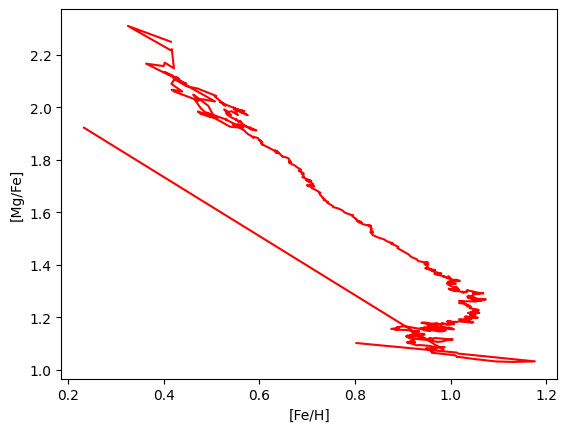

In [22]:
FeH_bins  = np.linspace(-1, 0.5, 100)
MgFe_bins = np.linspace(-0.2, 0.4, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(FeH[in_SN], MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[FeH_bins, MgFe_bins])

# plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')

plt.plot(avelogFe, avelogMgFe, c='r')

plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')

In [23]:
np.where(mbin < 0)[0]

array([], dtype=int64)

Text(0, 0.5, 'Z_Mg/Z_Fe')

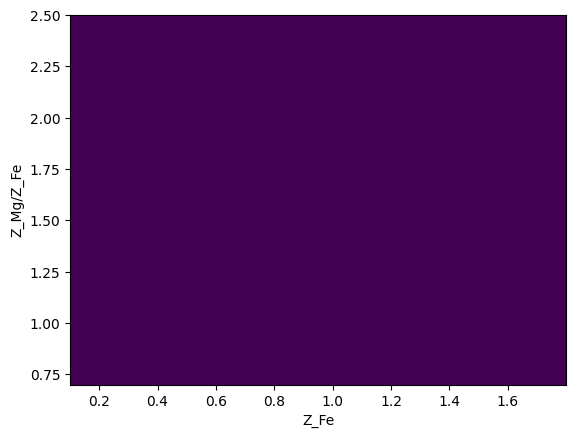

In [24]:
# FeH_bins  = np.linspace(-1, 0.5, 100)
# MgFe_bins = np.linspace(-0.2, 0.4, 100)
FeH_bins  = np.linspace(0.1, 1.8, 100)
MgFe_bins = np.linspace(0.7, 2.5, 100)

mbin, x_edge, y_edge, _ = binned_statistic_2d(10.**FeH[in_SN], 10.**MgFe[in_SN], np.full(len(np.where(in_SN)[0]), 1), 
                                                     statistic='sum', bins=[FeH_bins, MgFe_bins])

plt.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]])#, norm=mpl.colors.LogNorm())
plt.gca().set_aspect('auto')

# plt.plot(10.**aveFe, 10.**aveMgFe, c='r')

plt.xlabel('Z_Fe')
plt.ylabel('Z_Mg/Z_Fe')